In [38]:
from datasets import load_dataset
import numpy as np

SEED = 42


femnist = load_dataset("flwrlabs/femnist")

In [42]:
femnist["train"].info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None), 'writer_id': Value(dtype='string', id=None), 'hsf_id': Value(dtype='int64', id=None), 'character': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', dataset_name='femnist', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=269608012, num_examples=814277, shard_lengths=None, dataset_name='femnist')}, download_checksums={'hf://datasets/flwrlabs/femnist@df739a2b09df2b5cc1ec93107659b9a9a8566487/data/train-00000-of-00001.parquet': {'num_bytes': 200734290, 'ch

In [40]:
np.array(femnist["train"][0]["image"]).shape

(28, 28)

In [3]:
writer_id = femnist["train"].select_columns(["writer_id"]).to_pandas()

<Axes: >

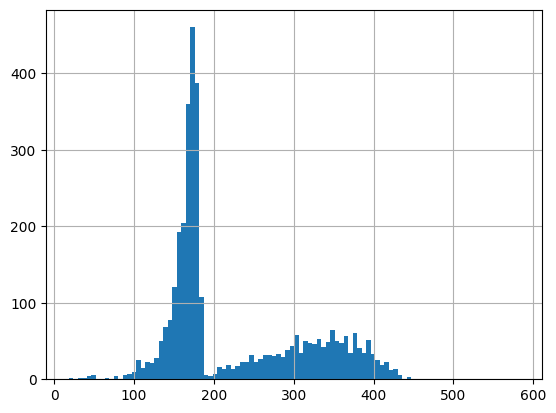

In [4]:
writer_id.groupby("writer_id").size().hist(bins=100)

In [5]:
writer_id.value_counts(sort=False).sample(frac=1.0, random_state=SEED)

writer_id
f3573_02     151
f1255_13     355
f3750_00     176
f1061_01     227
f1719_12     162
            ... 
f1130_48     288
f1294_12     331
f0860_21     396
f4010_12     162
f3677_29     171
Name: count, Length: 3597, dtype: int64

In [6]:
writer_id.value_counts(sort=False).sample(
    frac=1.0, random_state=SEED
).cumsum() / writer_id.shape[0]

writer_id
f3573_02     0.000185
f1255_13     0.000621
f3750_00     0.000838
f1061_01     0.001116
f1719_12     0.001315
               ...   
f1130_48     0.998698
f1294_12     0.999105
f0860_21     0.999591
f4010_12     0.999790
f3677_29     1.000000
Name: count, Length: 3597, dtype: float64

In [7]:
selected_writers = (
    writer_id.value_counts(sort=False).sample(frac=1.0, random_state=SEED).cumsum()
    / writer_id.shape[0]
) < 0.15
selected_writers

writer_id
f3573_02      True
f1255_13      True
f3750_00      True
f1061_01      True
f1719_12      True
             ...  
f1130_48     False
f1294_12     False
f0860_21     False
f4010_12     False
f3677_29     False
Name: count, Length: 3597, dtype: bool

In [8]:
selected_writers.sum()

528

In [9]:
selected_writers.sum() / selected_writers.shape[0]

0.14678899082568808

In [10]:
# num samples taken
n_samples_taken = (
    writer_id.value_counts(sort=False)
    .sample(frac=1.0, random_state=SEED)[selected_writers.values]
    .sum()
)
n_samples_taken

121948

In [11]:
n_samples_taken / writer_id.shape[0]

0.14976230447378472

In [12]:
writer_id.shape[0]

814277

In [13]:
selected_writer_ids_for_test = (
    writer_id.value_counts(sort=False)
    .sample(frac=1.0, random_state=SEED)[selected_writers.values]
    .reset_index()["writer_id"]
)


In [14]:
selected_writer_ids_for_test

0      f3573_02
1      f1255_13
2      f3750_00
3      f1061_01
4      f1719_12
         ...   
523    f2068_36
524    f0283_31
525    f0274_49
526    f2183_59
527    f2164_60
Name: writer_id, Length: 528, dtype: object

In [15]:
selected_writer_ids_for_test.to_csv('./../../configs/test_writer_ids_femnist.csv', index=False)

In [26]:
dataset = femnist
writer_id = dataset["train"].select_columns(["writer_id"]).to_pandas()

test_rows = writer_id["writer_id"].isin(selected_writer_ids_for_test)
test_rows_ids = writer_id[test_rows].index
train_rows_ids = writer_id[~test_rows].index

In [27]:
dataset_test = dataset["train"].select(test_rows_ids)
dataset_train = dataset["train"].select(train_rows_ids)

In [34]:
from datasets import DatasetDict
import pandas as pd

def resplit_femnist_to_train_test(dataset):
    selected_writer_ids_for_test = pd.read_csv('./../../configs/test_writer_ids_femnist.csv')['writer_id']
    writer_id = dataset["train"].select_columns(["writer_id"]).to_pandas()

    test_rows = writer_id["writer_id"].isin(selected_writer_ids_for_test)
    test_rows_ids = writer_id[test_rows].index
    train_rows_ids = writer_id[~test_rows].index
    dataset_test = dataset["train"].select(test_rows_ids)
    dataset_train = dataset["train"].select(train_rows_ids)
    return DatasetDict({"train": dataset_train, "test": dataset_test})

In [35]:
len(resplit_femnist_to_train_test(femnist)["train"].unique("writer_id"))

3069

In [36]:
len(resplit_femnist_to_train_test(femnist)["test"].unique("writer_id"))

528